<a href="https://colab.research.google.com/github/SCK22/SongClassification-StyleTransfer/blob/master/StyleTransfer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Loading Libraries

In [0]:
import os
import librosa
from IPython.display import Audio,display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
sess = tf.Session()


In [0]:
os.listdir('.')

['.config', 'drive', 'sample_data']

In [0]:
os.getcwd()

'/content'

In [0]:
!ls drive/My\ Drive/Gem/inputs


eminem.mp3    gettysburg.mp3  lemons.mp3  spongebob.mp3  valkyries.mp3
fire.mp3      imperial.mp3    nwa.mp3	  usa.mp3
futurama.mp3  imperial.wav    russia.mp3  usa.wav


#### Loading Data from Google Drive

In [0]:
CONTENT_FILENAME = "./drive/My Drive/Gem/inputs/imperial.wav"
STYLE_FILENAME = "./drive/My Drive/Gem/inputs/usa.wav" 


In [0]:
from  IPython.display import Audio,display

In [0]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

#### Reading the Spectogram 

In [0]:
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename,sr=22050)
    S = librosa.stft(x, N_FFT)
    print(S.shape)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:]))  
    return S, fs

In [0]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
print(N_SAMPLES)
print(N_CHANNELS)
a_style = a_style[:N_CHANNELS, :N_SAMPLES]
print(a_content[:5,:5])
print(a_style[:5,:5])
print(a_style.shape)

(1025, 431)
(1025, 431)
431
1025
[[5.0794153e-04 3.6759488e-02 1.3658285e-01 1.8637198e-01 2.5305111e-02]
 [3.0958952e-04 3.6279596e-02 2.4111338e-01 2.4687435e-01 6.3394576e-02]
 [6.2961997e-05 3.6948361e-02 4.3974951e-01 6.2219304e-01 3.5874921e-01]
 [6.9072106e-05 4.3598931e-02 5.8530200e-01 1.1319705e+00 1.1922586e+00]
 [9.5082869e-05 5.9612568e-02 6.2221843e-01 1.2103863e+00 1.5032799e+00]]
[[1.0963429e-03 3.6433081e-03 7.1805450e-03 1.1881496e-02 1.5604205e-02]
 [2.2773906e-04 2.9046151e-03 4.5461557e-03 2.6301593e-03 3.9511420e-02]
 [6.2182022e-05 1.8736408e-03 1.4644798e-03 2.6859641e-03 4.5400415e-02]
 [2.6794622e-04 1.2765123e-03 9.1057323e-04 4.0354393e-03 5.9468530e-02]
 [6.0166651e-04 1.3003836e-03 1.2083485e-03 3.3229007e-03 8.4524192e-02]]
(1025, 431)


In [0]:
print(a_style[0:,1])

[3.6433081e-03 2.9046151e-03 1.8736408e-03 ... 5.6725867e-07 9.2500727e-07
 9.1512231e-07]


In [0]:
plt.style.use('classic')

In [0]:
from librosa import display

#### plotting the Spectogram

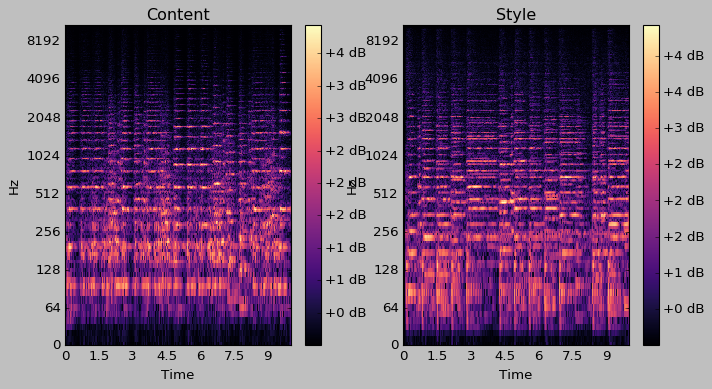

In [0]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
librosa.display.specshow(a_content, y_axis='log',x_axis='time')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
plt.title('Style')
librosa.display.specshow(a_style, y_axis='log',x_axis='time')
plt.colorbar(format='%+2.0f dB')



#### Adding the Filter Initialization

In [0]:
N_FILTERS = 2048

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

In [0]:
from sys import stderr

In [0]:
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")
kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')

#### Creating the Computational Graph

In [0]:
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")
    print(x)
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    relu_conv = tf.nn.leaky_relu(conv)
    net = tf.layers.max_pooling2d(inputs=relu_conv, pool_size=[1, 1], strides=1)
    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    print(content_features.shape)
    print(style_features.shape)
    features = np.reshape(style_features, (-1, N_FILTERS))
    print(features.shape)
    style_gram = np.matmul(features.T, features) / N_SAMPLES
    print(style_gram.shape)

Tensor("x:0", shape=(1, 1, 431, 1025), dtype=float32, device=/device:CPU:0)
Instructions for updating:
Use keras.layers.max_pooling2d instead.
(1, 1, 421, 2048)
(1, 1, 421, 2048)
(421, 2048)
(2048, 2048)


#### Minimizing the Total Loss

In [0]:
from sys import stderr

ALPHA= 1e-3
learning_rate= 1e-2
iterations = 1000

result = None
with tf.Graph().as_default():

    # Build graph with variable input

    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")
    print(x.shape)
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    relu_conv = tf.nn.leaky_relu(conv)
    net = tf.layers.max_pooling2d(inputs=relu_conv, pool_size=[1, 1], strides=1)
    print(net.get_shape)
    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())
    print("height=",height)
    print("width=",width)
    print("number=",number)
    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    print(feats.shape)
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = (10) * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter':1000})
   
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print ('Final loss:', loss.eval())
        result = x.eval()

Instructions for updating:
Colocations handled automatically by placer.
(1, 1, 431, 1025)
<bound method Tensor.get_shape of <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(1, 1, 421, 2048) dtype=float32>>
('height=', 1)
('width=', 421)
('number=', 2048)
(421, 2048)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  Objective function value: 81.790504
  Number of iterations: 1000
  Number of functions evaluations: 1039
('Final loss:', 81.790504)


#### Inverse FFT to get back Audio

In [0]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = './drive/My Drive/Gem/outputs/ouput_leakyrelu.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [0]:
from IPython.display import Audio,display
print( OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

./drive/My Drive/Gem/outputs/ouput_leakyrelu.wav


#### Plotting the Results

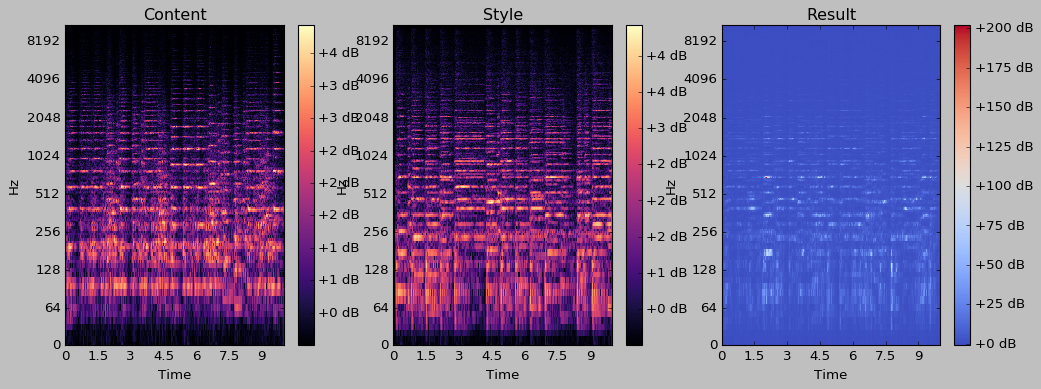

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
librosa.display.specshow(a_content, y_axis='log',x_axis='time')
plt.colorbar(format='%+2.0f dB')
#plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
librosa.display.specshow(a_style, y_axis='log',x_axis='time')
plt.colorbar(format='%+2.0f dB')
#plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
librosa.display.specshow(a, y_axis='log',x_axis='time')
plt.colorbar(format='%+2.0f dB')
#plt.imshow(a[:400,:])
plt.show()